24520270 - Huỳnh Phát Đạt  
DS201.Q11.1  
Bài thực hành số 3

## Import thư viện


In [1]:
!pip install tensorflow

In [2]:
!pip install vncorenlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 49.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for vncorenlp: filename=vncorenlp-1.0.3-py3-none-any.whl size=2645933 sha256=ef723ddffafb05d352dd582b907000a805352a289accf233b8a69d838f70d8bf
  Stored in directory: /root/.cache/pip/wheels/6f/19/20/ec7083125fd06db1a19d0d3ca18806ecf4e8ed1464713b4efa
Successfully built vncorenlp


In [3]:
!mkdir -p vncorenlp/models/wordsegmenter
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr
!mv VnCoreNLP-1.1.1.jar vncorenlp/
!mv vi-vocab vncorenlp/models/wordsegmenter/
!mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/

--2025-11-25 02:20:04--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27412575 (26M) [application/octet-stream]
Saving to: ‘VnCoreNLP-1.1.1.jar’

VnCoreNLP-1.1.1.jar 100%[===================>]  26.14M  --.-KB/s    in 0.1s    

2025-11-25 02:20:05 (235 MB/s) - ‘VnCoreNLP-1.1.1.jar’ saved [27412575/27412575]

--2025-11-25 02:20:05--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting respon

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense, Embedding, Input, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping

from vncorenlp import VnCoreNLP

## Chuẩn bị UIT-VSFC dataset


### Đọc dữ liệu

In [5]:
train_vsfc = pd.read_json('/content/drive/MyDrive/DS201/THUCHANH/Lab3/DATA/UIT_VSFC/UIT-VSFC-train.json')
dev_vsfc = pd.read_json('/content/drive/MyDrive/DS201/THUCHANH/Lab3/DATA/UIT_VSFC/UIT-VSFC-dev.json')
test_vsfc = pd.read_json('/content/drive/MyDrive/DS201/THUCHANH/Lab3/DATA/UIT_VSFC/UIT-VSFC-test.json')

In [6]:
X_train_vsfc = train_vsfc['sentence']
y_train_vsfc = train_vsfc['sentiment']

x_dev_vsfc = dev_vsfc['sentence']
y_dev_vsfc = dev_vsfc['sentiment']

x_test_vsfc = test_vsfc['sentence']
y_test_vsfc = test_vsfc['sentiment']

### Biến đổi tập nhãn

In [7]:
# hàm replace giá trị trong tập label
def encode_sentiment(series):
  mapping = {
    "positive": 2,
    "neutral": 1,
    "negative": 0
  }
  encoded_series = series.astype(str).str.strip().str.lower().map(mapping)

  if encoded_series.isnull().any():
      print(f"Warning: {encoded_series.isnull().sum()} NaN values found after encoding sentiments label")

  return encoded_series

In [8]:
y_train_vsfc = encode_sentiment(y_train_vsfc)
y_dev_vsfc = encode_sentiment(y_dev_vsfc)
y_test_vsfc = encode_sentiment(y_test_vsfc)

In [9]:
# Flatten labels
y_train_vsfc = y_train_vsfc.values.flatten()
y_dev_vsfc = y_dev_vsfc.values.flatten()
y_test_vsfc = y_test_vsfc.values.flatten()

### Tách từ bằng VnCoreNLP

In [10]:
vncorenlp = VnCoreNLP(
    "/content/vncorenlp/VnCoreNLP-1.1.1.jar",
    annotators="wseg",
    max_heap_size='-Xmx500m'
)

# hàm tách từ
def custom_tokenizer(text):
    tokens = vncorenlp.tokenize(str(text))[0]
    return " ".join(tokens)

### Xây dựng bộ từ vựng, word_to_index

In [11]:
# Xây dựng bộ từ vựng
word_dict = set()

for sent in X_train_vsfc:
    ws = custom_tokenizer(sent).lower()
    for w in ws.split():
        word_dict.add(w)

# Tạo word2index
words = list(word_dict)

word2index = {w: i+2 for i, w in enumerate(words)}
word2index["UNK"] = 1
word2index["PAD"] = 0

### Encode dữ liệu

In [12]:
MAX_LEN = 100
NUM_LABEL = 3

# hàm encode
def encoding(X, y):
  sentences = []
  for t in X:
    sentences.append(custom_tokenizer(t))

  X = []
  for s in sentences:
    sent = []
    for w in s.split():
      try:
        w = w.lower()
        sent.append(word2index[w])
      except:
        sent.append(word2index["UNK"])
    X.append(sent)

  X = pad_sequences(maxlen = MAX_LEN, sequences = X,
                    padding = "post", value = word2index["PAD"])

  y = to_categorical(y, num_classes=NUM_LABEL)

  return (X, y)

In [13]:
X_train_encoded, y_train_encoded = encoding(X_train_vsfc.values.flatten(), y_train_vsfc)
x_dev_encoded, y_dev_encoded = encoding(x_dev_vsfc.values.flatten(), y_dev_vsfc)
x_test_encoded, y_test_encoded = encoding(x_test_vsfc.values.flatten(), y_test_vsfc)

## Bài 1: Xây dựng mạng LSTM gồm 5 lớp với hidden size là 256 cho bài toán phân loại văn bản. Huấn luyện mô hình này trên bộ dữ liệu UIT-VSFC (Vietnamese Student Feedback Corpus) sử dụng Adam làm phương thức tối ưu tham số và đánh giá độ hiệu quả của mô hình sử dụng độ đo F1.

### Xây dựng model

In [14]:
# Xây dựng model
model_1 = Sequential()
model_1.add(Input(shape=(MAX_LEN, )))
model_1.add(Embedding(input_dim=len(word2index), output_dim=128))
model_1.add(LSTM(256, return_sequences=True))
model_1.add(LSTM(256, return_sequences=True))
model_1.add(LSTM(256, return_sequences=True))
model_1.add(LSTM(256, return_sequences=True))
model_1.add(LSTM(256))
model_1.add(Dense(NUM_LABEL, activation='softmax'))

In [15]:
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 128)       │       468,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 100, 256)       │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 256)       │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 100, 256)       │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 100, 256)       │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 256)            │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,964,355 (11.31 MB)

 Trainable params: 2,964,355 (11.31 MB)

 Non-trainable params: 0 (0.00 B)

### Huấn luyện

In [30]:
optimizer = Adam(learning_rate=0.00001)
loss = CategoricalCrossentropy()

model_1.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [31]:
# Train model
history_1 = model_1.fit(
    x=X_train_encoded,
    y=y_train_encoded,
    batch_size=64,
    epochs=10,
    validation_data=(x_dev_encoded, y_dev_encoded)
)

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 19s 77ms/step - accuracy: 0.4930 - loss: 0.8323 - val_accuracy: 0.5085 - val_loss: 0.8468
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - accuracy: 0.5035 - loss: 0.8302 - val_accuracy: 0.5085 - val_loss: 0.8468
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 0.4890 - loss: 0.8322 - val_accuracy: 0.5085 - val_loss: 0.8469
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - accuracy: 0.4946 - loss: 0.8345 - val_accuracy: 0.5085 - val_loss: 0.8469
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 0.4872 - loss: 0.8294 - val_accuracy: 0.5085 - val_loss: 0.8469
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.4998 - loss: 0.8280 - val_accuracy: 0.5085 - val_loss: 0.8470
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 0.4921 - loss: 0.8373 - val_accuracy: 0.5085 - val_loss: 0.8470
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - accuracy: 0.4922 - loss: 0.8254 - val_ac

### Đánh giá

In [32]:
# Predict
y_pred1_vsfc = model_1.predict(x_test_encoded)
y_pred1_vsfc = np.argmax(y_pred1_vsfc, axis=1)

print('F1 Score:', f1_score(y_test_vsfc, y_pred1_vsfc, average='macro'))

99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
F1 Score: 0.22287636669470143


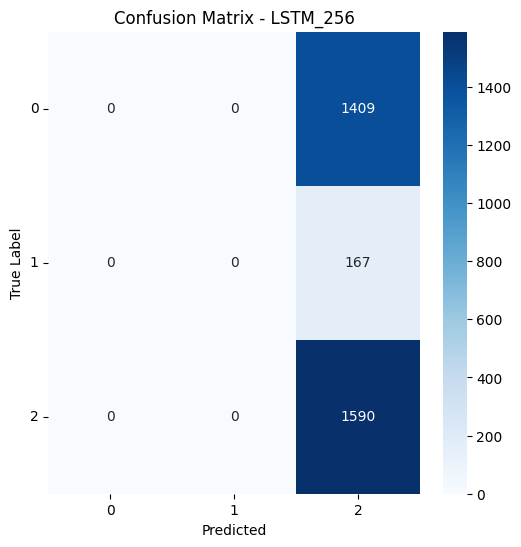

In [33]:
# Confunsion Matrix
cm = confusion_matrix(y_test_vsfc, y_pred1_vsfc)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix - LSTM_256')
plt.xlabel('Predicted')
plt.yticks(rotation=0)
plt.ylabel('True Label')
plt.show()

In [34]:
# save model
model_1.save('/content/drive/MyDrive/DS201/THUCHANH/Lab3/model/model_1.h5')

## Bài 2: Xây dựng mạng GRU gồm 5 lớp với hidden size là 256 cho bài toán phân loại văn bản. Huấn luyện mô hình này trên bộ dữ liệu UIT-VSFC (Vietnamese Student Feedback Corpus) sử dụng Adam làm phương thức tối ưu tham số và đánh giá độ hiệu quả của mô hình sử dụng độ đo F1.

### Xây dựng model

In [ ]:
# xây dựng model
model_2 = Sequential()
model_2.add(Input(shape=(MAX_LEN, )))
model_2.add(Embedding(input_dim=len(word2index), output_dim=128))
model_2.add(GRU(256, return_sequences=True))
model_2.add(GRU(256, return_sequences=True))
model_2.add(GRU(256, return_sequences=True))
model_2.add(GRU(256, return_sequences=True))
model_2.add(GRU(256))
model_2.add(Dense(NUM_LABEL, activation='softmax'))

In [ ]:
model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 128)       │       468,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 100, 256)       │       296,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 100, 256)       │       394,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 100, 256)       │       394,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 100, 256)       │       394,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ (None, 256)            │       394,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,344,323 (8.94 MB)

 Trainable params: 2,344,323 (8.94 MB)

 Non-trainable params: 0 (0.00 B)

### Huấn luyện

In [ ]:
optimizer = Adam(learning_rate=0.001)
loss = CategoricalCrossentropy()

model_2.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [ ]:
# train model_2
history_2 = model_2.fit(
    x=X_train_encoded,
    y=y_train_encoded,
    batch_size=32,
    epochs=10,
    validation_data=(x_dev_encoded, y_dev_encoded)
)

Epoch 1/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - accuracy: 0.5047 - loss: 0.8396 - val_accuracy: 0.7138 - val_loss: 0.7422
Epoch 2/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - accuracy: 0.7246 - loss: 0.6608 - val_accuracy: 0.8490 - val_loss: 0.4783
Epoch 3/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - accuracy: 0.8851 - loss: 0.3559 - val_accuracy: 0.9065 - val_loss: 0.3093
Epoch 4/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 19s 35ms/step - accuracy: 0.9239 - loss: 0.2521 - val_accuracy: 0.8989 - val_loss: 0.3208
Epoch 5/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - accuracy: 0.9310 - loss: 0.2288 - val_accuracy: 0.9059 - val_loss: 0.3073
Epoch 6/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.9374 - loss: 0.2032 - val_accuracy: 0.8996 - val_loss: 0.3282
Epoch 7/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.9441 - loss: 0.1755 - val_accuracy: 0.9015 - val_loss: 0.3132
Epoch 8/10
358/358 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - accuracy: 0.9406 - loss: 0.1918 - 

### Đánh giá

In [ ]:
# Predict
y_pred2_vsfc = model_2.predict(x_test_encoded)
y_pred2_vsfc = np.argmax(y_pred2_vsfc, axis=1)

print('F1 Score:', f1_score(y_test_vsfc, y_pred2_vsfc, average='macro'))

99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
F1 Score: 0.7091274858080919


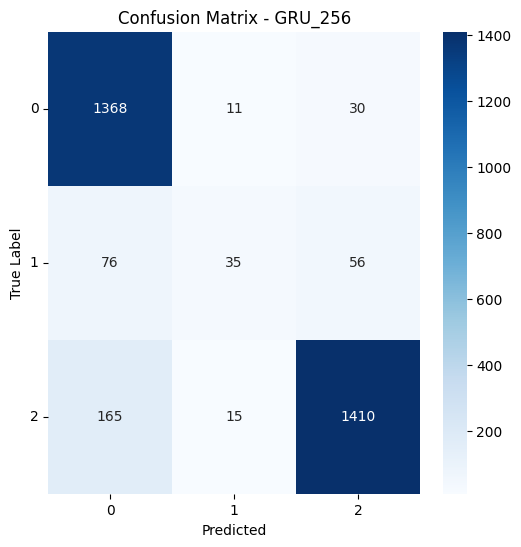

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test_vsfc, y_pred2_vsfc)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix - GRU_256')
plt.xlabel('Predicted')
plt.yticks(rotation=0)
plt.ylabel('True Label')
plt.show()

In [ ]:
# save model
model_2.save('/content/drive/MyDrive/DS201/THUCHANH/Lab3/model/model_2.h5')

## Chuẩn bị PhoNER dataset



In [5]:
!git clone https://github.com/VinAIResearch/PhoNER_COVID19.git

Cloning into 'PhoNER_COVID19'...
remote: Enumerating objects: 61, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 61 (delta 24), reused 41 (delta 17), pack-reused 0 (from 0)
Receiving objects: 100% (61/61), 3.61 MiB | 9.41 MiB/s, done.
Resolving deltas: 100% (24/24), done.


### Đọc dữ liệu

In [6]:
train = pd.read_json('/content/PhoNER_COVID19/data/word/train_word.json', lines=True)
dev = pd.read_json('/content/PhoNER_COVID19/data/word/dev_word.json', lines=True)
test = pd.read_json('/content/PhoNER_COVID19/data/word/test_word.json', lines=True)

In [7]:
train.head()

,words,tags
0,"[Đồng_thời, ,, bệnh_viện, tiếp_tục, thực_hiện,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1,"["", Số, bệnh_viện, có_thể, tiếp_nhận, bệnh_nhâ...","[O, O, O, O, O, O, O, B-SYMPTOM_AND_DISEASE, I..."
2,"[Ngoài_ra, ,, những, người, tiếp_xúc, gián_tiế...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
3,"[Bà, này, khi, trở, về, quá_cảnh, Doha, (, Qat...","[O, O, O, O, O, O, B-LOCATION, O, B-LOCATION, ..."
4,"["", Bệnh_nhân, 523, "", và, chồng, là, "", bệnh_...","[O, O, B-PATIENT_ID, O, O, O, O, O, O, B-PATIE..."


In [8]:
X_train_PhoNER = train['words']
y_train_PhoNER = train['tags']

X_dev_PhoNER = dev['words']
y_dev_PhoNER = dev['tags']

X_test_PhoNER = test['words']
y_test_PhoNER = test['tags']

### Xây dựng bộ từ vựng, tag, word_to_index, tag_to_index

In [9]:
# Xây dựng bộ từ vựng
word_dict1 = set()

for word in X_train_PhoNER:
  for w in word:
    word_dict1.add(w)

word_dict1 = {'<PAD>', '<UNK>'} | word_dict1
word1 = list(word_dict1)

# Tạo word2index
word2index1 = {w:i for i, w in enumerate(word1)}

In [10]:
# Xây dựng bộ tag
tag_dict1 = set()

for tag in y_train_PhoNER:
  for t in tag:
    tag_dict1.add(t)

tag_dict1 = {'<PAD>'} | tag_dict1
tag1 = list(tag_dict1)

# Tạo tag2index
tag2index1 = {t:i for i, t in enumerate(sorted(tag1))}

### Encode dữ liệu

In [11]:
MAX_LEN1 = 70

def encoding1(X, y):
    # Encode words
    X_encoded = [
        [word2index1.get(w, word2index1["<UNK>"]) for w in sent]
        for sent in X
    ]

    X = pad_sequences(sequences=X_encoded, maxlen=MAX_LEN1,
                      padding="post", value=word2index1["<PAD>"]
    )

    # Encode tags
    y_encoded = [
        [tag2index1[t] for t in tags]
        for tags in y
    ]

    y = pad_sequences(sequences=y_encoded, maxlen=MAX_LEN1,
                      padding="post", value=tag2index1["<PAD>"]
    )

    return X, y

In [12]:
X_train_encoded1, y_train_encoded1 = encoding1(X_train_PhoNER, y_train_PhoNER)
X_dev_encoded1, y_dev_encoded1 = encoding1(X_dev_PhoNER, y_dev_PhoNER)
X_test_encoded1, y_test_encoded1 = encoding1(X_test_PhoNER, y_test_PhoNER)

In [13]:
print(X_train_encoded1.shape)  # (num_samples, MAX_LEN1)
print(y_train_encoded1.shape)  # (num_samples, MAX_LEN1)

(5027, 70)
(5027, 70)


## Bài 3: Xây dựng kiến trúc Encoder trong đó Encoder gồm 5 lớp BiLSTM với hidden size là 256 cho bài toán nhận diện thực thể (Name Entity Recognition). Huấn luyện mô hình trên bộ dữ liệu PhoNER và đánh giá độ hiệu quả của mô hình sử dụng độ đo F1.

### Xậy dựng model

In [24]:
model_3 = Sequential()
model_3.add(Input(shape=(MAX_LEN1, )))
model_3.add(Embedding(input_dim=len(word2index1), output_dim=128))
model_3.add(Bidirectional(LSTM(256, return_sequences=True)))
model_3.add(Bidirectional(LSTM(256, return_sequences=True)))
model_3.add(Bidirectional(LSTM(256, return_sequences=True)))
model_3.add(Bidirectional(LSTM(256, return_sequences=True)))
model_3.add(Bidirectional(LSTM(256, return_sequences=True)))
model_3.add(TimeDistributed(Dense(len(tag2index1), activation='softmax')))

In [25]:
model_3.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 70, 128)        │       671,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 70, 512)        │       788,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ (None, 70, 512)        │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 70, 512)        │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 70, 512)        │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ (None, 70, 512)        │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 70, 21)         │        10,773 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,770,005 (29.64 MB)

 Trainable params: 7,770,005 (29.64 MB)

 Non-trainable params: 0 (0.00 B)

### Huấn luyện

In [26]:
optimizer = Adam(learning_rate=0.001)
loss = SparseCategoricalCrossentropy()

model_3.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [32]:
# sử dụng early stopping dựa trên val_loss
callback = EarlyStopping(monitor='val_loss', patience=5)

# train model
history_3 = model_3.fit(
    x=X_train_encoded1,
    y=y_train_encoded1,
    batch_size=32,
    epochs=20,
    callbacks=[callback],
    validation_data=(X_dev_encoded1, y_dev_encoded1)
)

Epoch 1/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 13s 83ms/step - accuracy: 0.9978 - loss: 0.0072 - val_accuracy: 0.9819 - val_loss: 0.0997
Epoch 2/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 13s 83ms/step - accuracy: 0.9982 - loss: 0.0058 - val_accuracy: 0.9825 - val_loss: 0.0987
Epoch 3/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 13s 83ms/step - accuracy: 0.9973 - loss: 0.0091 - val_accuracy: 0.9820 - val_loss: 0.0999
Epoch 4/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 13s 83ms/step - accuracy: 0.9981 - loss: 0.0063 - val_accuracy: 0.9822 - val_loss: 0.1027
Epoch 5/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 13s 84ms/step - accuracy: 0.9990 - loss: 0.0036 - val_accuracy: 0.9818 - val_loss: 0.1169
Epoch 6/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 13s 84ms/step - accuracy: 0.9991 - loss: 0.0032 - val_accuracy: 0.9831 - val_loss: 0.1074
Epoch 7/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 13s 85ms/step - accuracy: 0.9992 - loss: 0.0030 - val_accuracy: 0.9808 - val_loss: 0.1249


### Đánh giá

In [33]:
# Predict
y_pred3_PhoNER = model_3.predict(X_test_encoded1)
y_pred3_PhoNER = np.argmax(y_pred3_PhoNER, axis=2)

y_true = []
y_pred = []

for true, pred in zip(y_test_encoded1, y_pred3_PhoNER):
  for t, p in zip(true, pred):
    if t != tag2index1['<PAD>']: # bỏ qua padding
      y_true.append(t)
      y_pred.append(p)

print('F1 Score:', f1_score(y_true, y_pred, average='macro'))

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step
F1 Score: 0.7124006053357104


In [34]:
# Tạo index_to_tag
idx2tag = {i: t for t, i in tag2index1.items()}

y_true_tags = [idx2tag[i] for i in y_true]
y_pred_tags = [idx2tag[i] for i in y_pred]

# Classification report
print(classification_report(y_true_tags, y_pred_tags, digits=4, zero_division=0))

                       precision    recall  f1-score   support

                B-AGE     0.9197    0.9327    0.9262       565
               B-DATE     0.9741    0.9414    0.9574      1637
             B-GENDER     0.9317    0.9253    0.9285       442
                B-JOB     0.4301    0.4854    0.4560       171
           B-LOCATION     0.9417    0.8152    0.8739      4422
               B-NAME     0.9006    0.5142    0.6546       317
       B-ORGANIZATION     0.8750    0.7950    0.8331       766
         B-PATIENT_ID     0.9618    0.8305    0.8914      1971
B-SYMPTOM_AND_DISEASE     0.8675    0.7903    0.8271      1135
     B-TRANSPORTATION     0.8733    0.6788    0.7638       193
                I-AGE     1.0000    0.1667    0.2857         6
               I-DATE     0.9669    0.9837    0.9752      1722
                I-JOB     0.4483    0.2281    0.3023       114
           I-LOCATION     0.9511    0.8002    0.8691      4889
               I-NAME     0.8000    0.3077    0.4444  

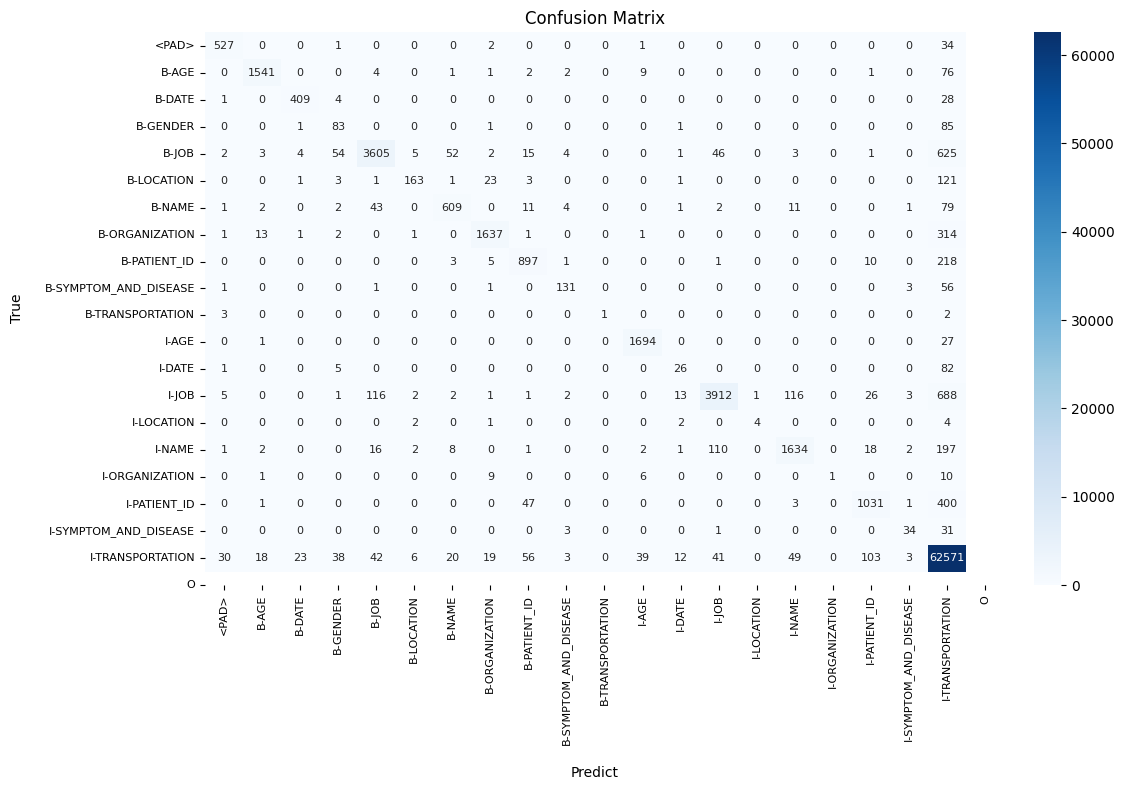

In [35]:
# Confusion matrix
cm = confusion_matrix(y_true_tags, y_pred_tags)
plt.figure(figsize=(12,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", annot_kws={"size":8},
            xticklabels=list(tag2index1.keys()), yticklabels=list(tag2index1.keys()))
plt.xlabel("Predict", labelpad=15)
plt.ylabel("True", labelpad=15)
plt.xticks(size=8)
plt.yticks(size=8)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [36]:
# save model
model_3.save('/content/drive/MyDrive/DS201/THUCHANH/Lab3/model/model_3.h5')